<a href="https://colab.research.google.com/github/DABallentine/knowledge_discovery_charlotte/blob/Kevin/311_Calls_Analysis_10_29_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discovering Knowledge for the City of Charlotte, NC
This project is a course requirement for DSBA-6162, Knowledge Discovery in Databases, at UNCC for the Fall semester, 2021.

<b>Team Members:</b> <br>
Naomi Thammadi <br>
Kevin Gharavizadeh <br>
Imad Ahmad <br>
Dustin Ballentine <br>

<h2> Project Motivation </h2>
The city of Charlotte has, like many cities, made large volumes of data open to the public in an online repository. This open data provides substantial potential for the city to benefit from knowledge discovery and insights generated by members of the public, such as ourselves. Service requests dialed to 311 represent a large opportunity to delve into the needs of the population and potentially extract useful trends that could allow the city to improve its service to its citizens. The goal of this project is to explore and uncover exactly those trends in the hope that the knowledge we discover may be used by the city to improve the quality of life of our families, friends, and neighbors.

<h2> Research Question(s) </h2>
<b>Do different areas within the city of Charlotte experience higher recurrence of any type of 311 service request than other areas, and do those areas correlate with red-line districts or other known demographic or socioeconomic profiles?</b>

<h2> Data Resources </h2>

<a href="https://data.charlottenc.gov/datasets/charlotte::service-requests-311/about"> 311 Service Requests </a> retrieved 30 September, 2021. 

<a href= "https://data.charlottenc.gov/datasets/census-household-income-block-groups/explore?location=35.259200%2C-80.807850%2C10.90"> Household Income </a> retrieved 12 October, 2021. 

<h2> Data Survey </h2>

In [1]:
#install packages, and download a few new ones 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

import descartes

!pip install geopandas 
import geopandas as gpd

from shapely.geometry import Point, Polygon

%matplotlib inline

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 40.9 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


In [2]:
#mount and connect my drive to access data files 

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#311 CSV file 
requests = pd.read_csv('/content/gdrive/MyDrive/Data/Service_Requests_311.csv')


In [4]:
requests.head()

X              Y  ...       PID Shape
0  1.458251e+06  508075.000119  ...  20904304   NaN
1  1.468687e+06  587225.999953  ...  02731251   NaN
2  1.471481e+06  562512.999839  ...  08917486   NaN
3  1.438992e+06  568604.000124  ...  03925515   NaN
4           NaN            NaN  ...       NaN   NaN

[5 rows x 30 columns]

In [5]:
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631510 entries, 0 to 1631509
Data columns (total 30 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   X                           1559084 non-null  float64
 1   Y                           1559084 non-null  float64
 2   OBJECTID                    1631510 non-null  int64  
 3   DEPARTMENT                  1631510 non-null  object 
 4   DIVISION                    1623095 non-null  object 
 5   REQUEST_NO                  1631510 non-null  int64  
 6   FISCAL_YEAR                 1631510 non-null  int64  
 7   FISCAL_MONTH                1631510 non-null  object 
 8   REQUEST_TYPE                1631510 non-null  object 
 9   RECEIVED_DATE               1631510 non-null  object 
 10  INTERNAL_FIELD_OBSERVATION  1631510 non-null  object 
 11  TITLE                       1631510 non-null  object 
 12  CMPD_DIVISION               45672 non-null    object 
 1

**Variable Selection** 
Following Variables are either: Redundant, large amouunt of NaN Values. 

X 

Y

Fiscal_Year

Fiscal_Month

CMPD_Division

Street_Directions

Street_name

Street_Type

City

State 

Council_District 

Global_ID

PID 

Shape 

In [6]:
requests.drop(requests.iloc[:, [0,1,12,15,16,17,18,19,26,27,28,29]], axis=1, inplace =True)
requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631510 entries, 0 to 1631509
Data columns (total 18 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   OBJECTID                    1631510 non-null  int64  
 1   DEPARTMENT                  1631510 non-null  object 
 2   DIVISION                    1623095 non-null  object 
 3   REQUEST_NO                  1631510 non-null  int64  
 4   FISCAL_YEAR                 1631510 non-null  int64  
 5   FISCAL_MONTH                1631510 non-null  object 
 6   REQUEST_TYPE                1631510 non-null  object 
 7   RECEIVED_DATE               1631510 non-null  object 
 8   INTERNAL_FIELD_OBSERVATION  1631510 non-null  object 
 9   TITLE                       1631510 non-null  object 
 10  NEIGHBORHOOD_PROFILE_AREA   1559062 non-null  float64
 11  BLOCK_NO                    1587157 non-null  float64
 12  ZIP_CODE                    1586427 non-null  float64
 1

In [7]:
requests.head()

OBJECTID             DEPARTMENT  ...   LATITUDE  LONGITUDE
0         1   Solid Waste Services  ...  35.132444 -80.812089
1         2  Housing and NBHD Serv  ...  35.350408 -80.781941
2         3   Solid Waste Services  ...  35.282654 -80.771094
3         4   Solid Waste Services  ...  35.297745 -80.880327
4         5                Transit  ...        NaN        NaN

[5 rows x 18 columns]

In [8]:
requests.describe()

OBJECTID    REQUEST_NO  ...      LATITUDE     LONGITUDE
count  1.631510e+06  1.631510e+06  ...  1.559077e+06  1.559077e+06
mean   8.158046e+05  7.321723e+06  ...  3.521283e+01 -8.082195e+01
std    4.710376e+05  6.148555e+05  ...  8.379533e-02  8.065106e-02
min    1.000000e+00  5.472783e+06  ...  3.501230e+01 -8.556829e+01
25%    4.078782e+05  6.781959e+06  ...  3.515058e+01 -8.087012e+01
50%    8.157555e+05  7.326774e+06  ...  3.521909e+01 -8.081576e+01
75%    1.223807e+06  7.862086e+06  ...  3.527270e+01 -8.076559e+01
max    1.631684e+06  8.370087e+06  ...  3.551843e+01 -7.607136e+01

[8 rows x 10 columns]

In [9]:
#Checking for missing data 
requests.isnull().sum()

OBJECTID                          0
DEPARTMENT                        0
DIVISION                       8415
REQUEST_NO                        0
FISCAL_YEAR                       0
FISCAL_MONTH                      0
REQUEST_TYPE                      0
RECEIVED_DATE                     0
INTERNAL_FIELD_OBSERVATION        0
TITLE                             0
NEIGHBORHOOD_PROFILE_AREA     72448
BLOCK_NO                      44353
ZIP_CODE                      45083
FULL_ADDRESS                   7168
X_COORD                       72426
Y_COORD                       72426
LATITUDE                      72433
LONGITUDE                     72433
dtype: int64

In [10]:
#drop missing values 
#requests = requests.dropna()

In [11]:
requests.shape

(1631510, 18)

In [12]:
#Observe the top request types, department, and division. 
#Identify any large differences between department and division? 

print(requests['REQUEST_TYPE'].value_counts().head(30))



NON_RECYCLABLE ITEMS         831737
RECYCLABLE ITEMS             199452
HNS HEALTH AND SANITATION     85031
CART REPAIR-GARBAGE           36541
MISSED RECYCLING              27471
SW DOCUMENT GARBAGE           26729
311 DOCUMENT                  25395
CDOT STREETLIGHT REPAIR       19216
SW DOCUMENT RECYCLING         17932
DEAD ANIMAL COLLECTION        16727
CART ISSUE/MISSING CART       15121
TIRES                         13577
SW DOCUMENT YARD WASTE        13186
CART DELIVERY RECYCLING       11835
COMPLAINT                     11788
ZONING/COMPLAINT/ INSPECT     11767
CART(S) DEL- NEW BUILD        11324
CART ONLY DELIVER-GARB        11235
CART REPAIR-RECYCLE            9933
ZON GENERAL INFO  INQUIRY      9805
CDOT POTHOLE REPAIR            9416
HNS HOUSING                    8405
CART PURCHASE 2ND-GARBAGE      8077
MISSED GARBAGE                 7330
CDOT STREET SIGN REP/REPL      7260
PARKING ON LAWN WORKDAYS       6956
STREET SWEEPING/FLUSHING       6824
GRAFFITI                    

In [13]:
requests.REQUEST_TYPE.value_counts().TIRES
#Confirm how to check specific value count for something with spaces in between 

13577

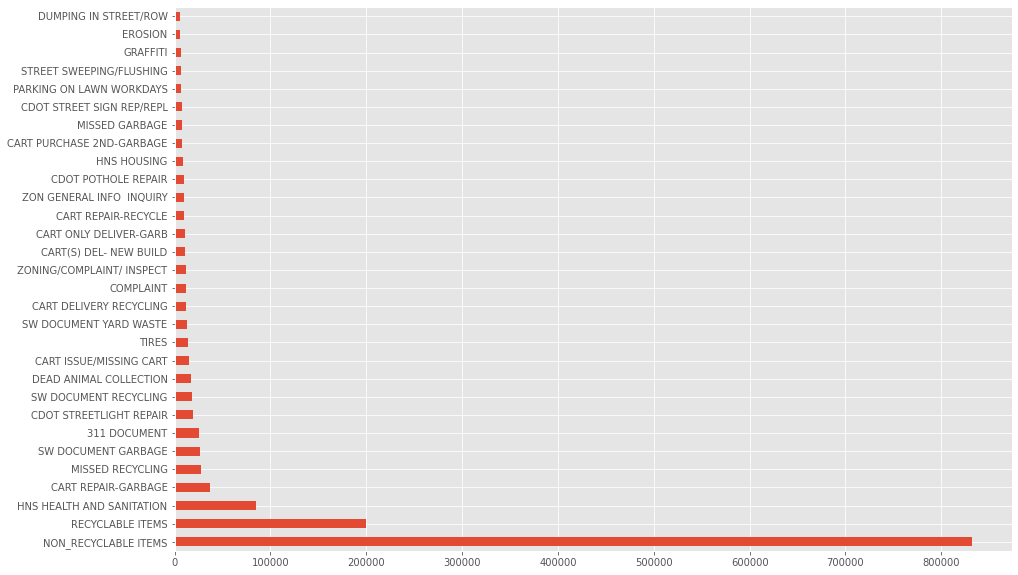

In [14]:
requests['REQUEST_TYPE'].value_counts().head(30).plot(kind='barh', figsize=(15,10))

Request Types Taper off very dramatically, review the bottom requests 

In [15]:
print("Bottom 30 categories by volume")
print(requests['REQUEST_TYPE'].value_counts().tail(30).sort_values())

Bottom 30 categories by volume
DISABILITY ACT                1
ON CALL - SWS SPEC SERV       1
COMPLEX PROBLEM               1
UT/MANDATORY                  1
SW FIELD OBSERVED TO CI       1
UT/LANDSCAPE                  1
BUS STOP-REMOVE TRASH CAN     1
SW EXCESSIVE STORM-SW USE     1
SWS MLTFMLY FIELD OBSERVE     1
SW REMINDER BULKY-SW USE      2
SW REMINDER GARB-SW USE       4
NEW SVC BUSINESS GARBAGE      5
CART REPAIR-BUSN GARB         6
SW ESCALATION REQUEST         6
BUS STOP-TRASH CAN MISC       6
CART DELIVERY BUSN GARB       7
OPINION                       7
BUS FACILITIES MAINT          8
BULKY ITEM SCHEDULE           8
LAND DEVELOPMENT INQUIRY      8
SMOKING VEHICLE REPORT        9
UT RATE CHANGE                9
CART ONLY DELIVER-RECY       10
BUS STOP-FULL TRASH  CAN     10
MUD IN THE STREET            10
PARK & REC REFUND/CANCEL     11
DISABLED INSPECTION (SWS)    12
SWS CART RETIRE REVIEW       12
ZON APPEALS/CITATIONS INQ    14
CWP REQUEST-HIGH PRIORITY    16
Name: REQ

In [16]:
requests['REQUEST_TYPE'].unique().tolist()

['NON_RECYCLABLE ITEMS',
 'UTILITY VERIFICATION LTR',
 'MISSED RECYCLING',
 'CITIZEN FEEDBACK',
 'CWP REQUEST',
 'RECYCLABLE ITEMS',
 'CART REPAIR-GARBAGE',
 '311 DOCUMENT',
 'HNS HEALTH AND SANITATION',
 'ZON DAYCARE/CHILDCARE INQ',
 'CDOT STREETLIGHT REPAIR',
 'ZON SIGNS INQUIRY',
 'CART ISSUE/MISSING CART',
 'CART(S) DEL- NEW BUILD',
 'CART REPAIR-RECYCLE',
 'CDOT STREET SIGN REP/REPL',
 'SW DOCUMENT BULKY ITEMS',
 'TIRES',
 'LANDSCAPE TREES',
 'CART DELIVERY RECYCLING',
 'TAX BILL INQUIRY',
 'CART PURCHASE 2ND-GARBAGE',
 'FIELD OBSERVED PROBLEM',
 'SW DOCUMENT YARD WASTE',
 'LITTER/DEBRIS IN STREET',
 'SWS CART SHIPMT REVIEW',
 'ZONGROUP/BOARDING HOMES',
 'INVALID/NEW SW ADDRESS',
 'FLOODING',
 'SW DOCUMENT GARBAGE',
 'DEAD ANIMAL COLLECTION',
 'SW DOCUMENT RECYCLING',
 'ZON RESIDENTIAL PERMITS',
 'INVESTIGATE/CONTACT RECY',
 'HNS HOUSING',
 'CART ONLY DELIVER-GARB',
 'CART PURCHASE 2ND-RECYCLE',
 'CDOT TRAF SIGNAL TIMING',
 'CART PICKUP-RECYCLE',
 '3-1-1 ESCALATION REQUEST',
 'CDO

In [17]:
print("Top 30 departments by volume:\n")
print(requests['DEPARTMENT'].value_counts().head(30))



Top 30 departments by volume:

Solid Waste Services         1330678
Housing and NBHD Serv         181627
Transportation                 70953
Storm Water Services           19094
Police                          8810
UT-Utilities                    7445
Eng & Prop Mgmt/City            5266
Mecklenburg County              1772
NCDOT                           1474
Finance/City                    1061
Planning/City                    881
Transit                          827
City Manager                     701
Fire/City                        195
Shared Services                  190
Mayor                            181
Human Resources/City             156
Aviation                         119
Cnty Mngr./ Commissioners         36
Strategy and Budget               17
Health Dept/Cnty                  14
City Clerk                         6
City Attorney                      4
Char Business Inclusion            2
Procurement/City                   1
Name: DEPARTMENT, dtype: int64


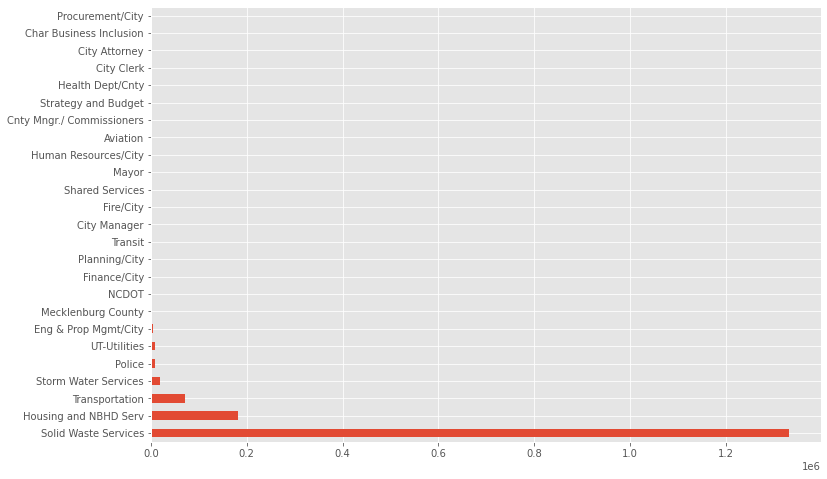

In [18]:
requests['DEPARTMENT'].value_counts().head(30).plot(kind='barh', figsize=(12,8))

In [19]:
print("Top 30 Divisions by volume:\n")
print(requests['DIVISION'].value_counts().head(30))

Top 30 Divisions by volume:

Sanitation                   1073928
HNS Code Enforcement          149698
Carts - Otto                  103170
Multifamily (Bulky)            90899
CDOT Customer Service          47203
Special Services               33553
311 Partner Liaison            31671
Street Maintenance             23750
Storm Water- City              15238
SWS Carts Admin                 9750
Multifamily (Garb / Recy)       5532
Landscape Manage./City          5084
Police/COVID Response           4324
UT-Administration               4272
Storm Water- County             3856
SW Contract Monitors            2953
Solid Waste Admin               2772
SW Addresses                    2436
311 Utility Escalation          2061
Animal Control                  2029
SWS Cust Svc Liaison Team       1943
CWP Resolution Team              990
UT-Field Operations              830
Land Development/City            720
Park and Recreation/Cnty         713
Tax Assessor Office              614
SW Multi-

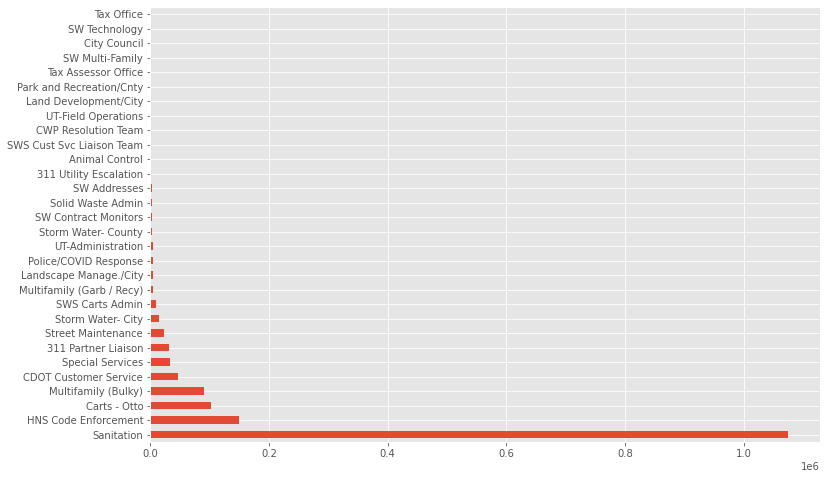

In [20]:
requests['DIVISION'].value_counts().head(30).plot(kind='barh', figsize=(12,8))

In [21]:
requests['FULL_ADDRESS'].value_counts().head(50)

 PROVIDENCE RD, CHARLOTTE, NC  28211             603
8301 SHARON LAKES RD, CHARLOTTE, NC  28210       563
 E W T HARRIS BV, CHARLOTTE, NC  28213           419
 REA RD, CHARLOTTE, NC  28277                    413
 PARK RD, CHARLOTTE, NC  28210                   412
 S TRYON ST, CHARLOTTE, NC  28262                399
 N TRYON ST, CHARLOTTE, NC  28202                366
 CARMEL RD, CHARLOTTE, NC  28226                 350
1120 MARBLE ST, CHARLOTTE, NC  28208             327
3642 HUYTON CT, CHARLOTTE, NC  28215             320
5015 CHERRYCREST LN, CHARLOTTE, NC  28217        310
4624 SHARON CHASE DR, CHARLOTTE, NC  28215       309
5200 AMITY SPRINGS DR, CHARLOTTE, NC  28212      306
1357 SHARON RD WEST, CHARLOTTE, NC  28210        305
6619 YATESWOOD DR, CHARLOTTE, NC  28212          301
201 S HOSKINS RD, CHARLOTTE, NC  28208           298
2868 HEATHSTEAD PL, CHARLOTTE, NC  28210         298
1207 KELSTON PL, CHARLOTTE, NC  28212            298
1701 WEST BV, CHARLOTTE, NC  28208            

In [22]:
print(requests['ZIP_CODE'].value_counts().head(50))


28269.0    147496
28216.0    117044
28208.0    112955
28215.0    112076
28205.0    107186
28277.0     88085
28226.0     85083
28214.0     82944
28210.0     75870
28213.0     70879
28270.0     64466
28212.0     64111
28273.0     57886
28211.0     56663
28227.0     51998
28262.0     49794
28217.0     48851
28209.0     43164
28206.0     31169
28278.0     26350
28203.0     24768
28105.0     18473
28207.0     15137
28202.0     11608
28204.0     10979
28078.0      2203
28134.0      2196
28031.0      1480
28104.0       575
28036.0       457
28272.0       334
282.0         187
28266.0       183
26216.0       168
29745.0       159
28219.0       121
28218.0       113
28201.0        89
28222.0        86
28220.0        77
28223.0        75
28221.0        71
26269.0        67
28295.0        65
28279.0        60
28028.0        58
28263.0        55
28265.0        54
28261.0        48
28025.0        48
Name: ZIP_CODE, dtype: int64


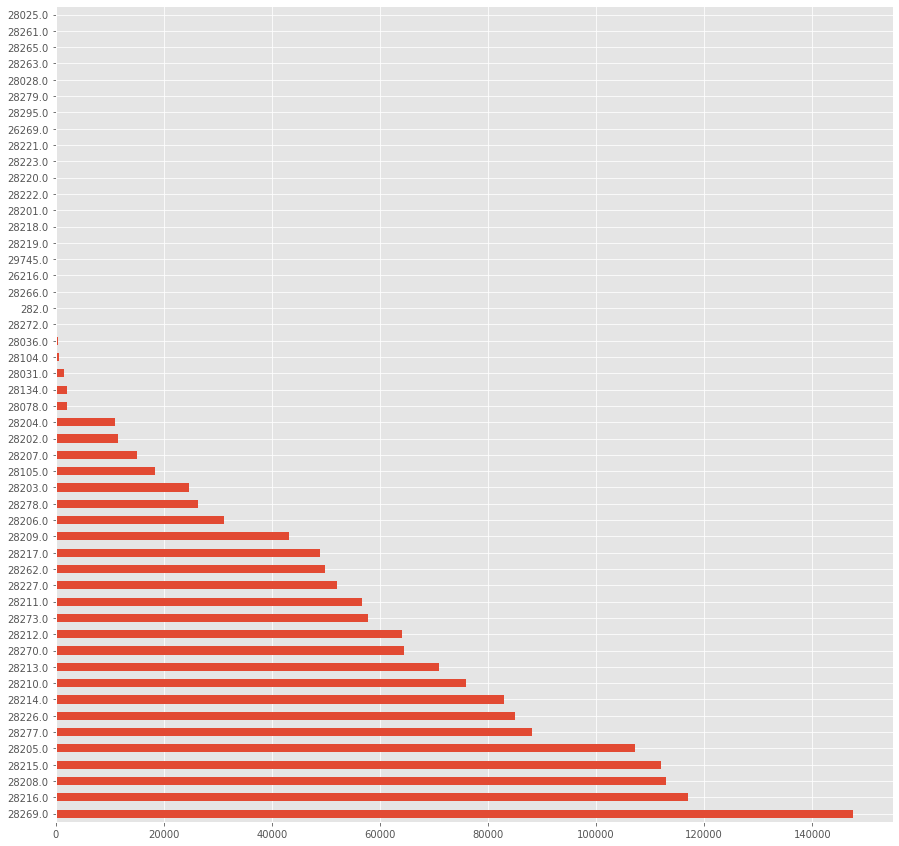

In [23]:
requests['ZIP_CODE'].value_counts().head(50).plot(kind='barh', figsize=(15,15))

**Notice there is wrong zip code: 282.0**
**Remove it and confirm that has been removed **

In [24]:
requests[requests["ZIP_CODE"] == 282.0]

OBJECTID            DEPARTMENT  ...   LATITUDE  LONGITUDE
1038         1039  Solid Waste Services  ...  35.187113 -80.785858
8775         8776  Solid Waste Services  ...        NaN        NaN
21396       21397  Solid Waste Services  ...  35.145283 -80.979931
24793       24794  Solid Waste Services  ...  35.258635 -80.750157
44690       44691  Solid Waste Services  ...  35.289272 -80.716110
...           ...                   ...  ...        ...        ...
1603018   1603193  Solid Waste Services  ...  35.205888 -80.826178
1609706   1609881  Solid Waste Services  ...  35.215168 -80.701489
1614321   1614496  Solid Waste Services  ...  35.211094 -80.736572
1614324   1614499  Solid Waste Services  ...  35.211094 -80.736572
1620618   1620793  Solid Waste Services  ...  35.217864 -80.741261

[187 rows x 18 columns]

In [25]:
requests.drop(requests.index[requests['ZIP_CODE'] == 282.0], inplace = True)


#requests[(requests.ZIP_CODE != 282.0)

#requests.drop(requests.ZIP_CODE[requests['ZIP_CODE']== 282.0]

(requests.ZIP_CODE == 282.0).sum()

0

# Import Shape file and begin geo pandas and visualizations

In [26]:
#SHP Visual with zipcode boundaries 
charlotte_zipcode_map = gpd.read_file('/content/gdrive/MyDrive/Data/zipcode/Zipcode.shp')

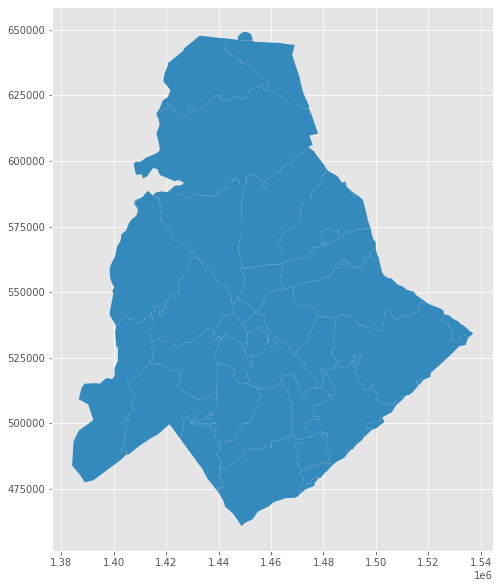

In [27]:
#This map seems better. Perhaps we can get it to change the colors for each zone 

fig, ax = plt.subplots(figsize = (10,10))
charlotte_zipcode_map.plot(ax= ax)

# **Look at the Shape file and confirm which coordinate system to use 

In [28]:
charlotte_zipcode_map.head(50)

objectid_1  ...                                           geometry
0            1  ...  POLYGON ((1474271.666 605253.751, 1476487.623 ...
1            2  ...  POLYGON ((1489318.124 589639.188, 1489488.625 ...
2            3  ...  POLYGON ((1464573.491 560419.792, 1464454.104 ...
3            4  ...  POLYGON ((1414807.123 586940.379, 1414954.627 ...
4            5  ...  POLYGON ((1408118.000 583191.500, 1407986.125 ...
5            6  ...  POLYGON ((1408351.250 578936.625, 1408611.625 ...
6            7  ...  POLYGON ((1437644.104 556907.910, 1438927.856 ...
7            8  ...  POLYGON ((1468497.625 547893.375, 1468575.563 ...
8            9  ...  POLYGON ((1447492.752 547889.876, 1448152.516 ...
9           10  ...  POLYGON ((1446268.503 541410.940, 1446321.699 ...
10          11  ...  POLYGON ((1465230.757 530463.216, 1466855.194 ...
11          12  ...  POLYGON ((1479727.609 520873.289, 1480199.746 ...
12          13  ...  POLYGON ((1478065.381 479246.583, 1477870.423 ...
13          14  ...  POLYGON ((1518078.374 516543.598, 1516862.250 ...
14          15  ...  POLYGON ((1533256.752 537411.626, 1534726.112 ...
15          16  ...  POLYGON ((1507751.941 506962.983, 1507432.723 ...
16          17  ...  POLYGON ((1479365.996 540531.316, 1479374.998 ...
17          18  ...  POLYGON ((1484368.269 573202.952, 1484584.751 ...
18          19  ...  POLYGON ((1485243.964 594276.741, 1487171.249 ...
19          20  ...  POLYGON ((1455088.746 542893.936, 1454936.356 ...
20          21  ...  POLYGON ((1455539.345 536732.304, 1455828.495 ...
21          22  ...  POLYGON ((1436219.750 535790.751, 1437092.998 ...
22          23  ...  POLYGON ((1447865.946 646079.325, 1447549.992 ...
23          24  ...  POLYGON ((1414982.394 539650.199, 1415059.500 ...
24          25  ...  POLYGON ((1503207.483 500560.552, 1500066.348 ...
25          26  ...  POLYGON ((1519014.626 546125.816, 1519281.157 ...
26          27  ...  POLYGON ((1448123.559 592540.707, 1447724.469 ...
27          28  ...  POLYGON ((1498290.002 572581.313, 1498891.250 ...
28          29  ...  POLYGON ((1446744.557 531434.213, 1446940.523 ...
29          30  ...  POLYGON ((1443895.926 642035.338, 1443343.275 ...
30          31  ...  POLYGON ((1500474.123 564262.998, 1501300.374 ...
31          32  ...  POLYGON ((1447865.946 646079.325, 1449295.878 ...
32          33  ...  POLYGON ((1457249.014 628490.513, 1457117.013 ...
33          34  ...  POLYGON ((1468625.496 496052.996, 1469032.296 ...
34          35  ...  POLYGON ((1439988.296 522860.995, 1440127.796 ...
35          36  ...  POLYGON ((1463516.472 515990.305, 1463700.261 ...
36          37  ...  POLYGON ((1437057.386 503394.754, 1436699.822 ...
37          38  ...  POLYGON ((1415869.875 522486.687, 1418576.249 ...
38          39  ...  POLYGON ((1468443.246 518532.286, 1468476.996 ...
39          40  ...  POLYGON ((1491585.596 526076.295, 1492140.126 ...
40          41  ...  POLYGON ((1489417.998 488753.043, 1488452.876 ...
41          42  ...  POLYGON ((1475432.975 617751.452, 1475195.458 ...

[42 rows x 6 columns]

CRS referes to coordinatae reference system. CRS tells python how these coordinates relate to a place on earth 

We need to convert our pandas dataframe into a **geo** **dataframe** and create a **geometry** column

In [29]:

crs= {'init': 'epsg:4326'}
requests.head()

OBJECTID             DEPARTMENT  ...   LATITUDE  LONGITUDE
0         1   Solid Waste Services  ...  35.132444 -80.812089
1         2  Housing and NBHD Serv  ...  35.350408 -80.781941
2         3   Solid Waste Services  ...  35.282654 -80.771094
3         4   Solid Waste Services  ...  35.297745 -80.880327
4         5                Transit  ...        NaN        NaN

[5 rows x 18 columns]

we now need to create "points", points describe our long and lat into a data point. 
make sure to always specify longitude column before lat
In our case we will be using the 'X_COORD' and 'Y_CORD' as the city has their own system

In [30]:
geometry= [Point(xy) for xy in zip(requests['X_COORD'], requests['Y_COORD'])]
geometry[:3]

In [31]:
geo_requests = gpd.GeoDataFrame(requests,
                                  crs=crs,
                                  geometry= geometry)
geo_requests.head()

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


OBJECTID  ...                            geometry
0         1  ...  POINT (1458251.00000 508075.00000)
1         2  ...  POINT (1468687.00000 587226.00000)
2         3  ...  POINT (1471481.00000 562513.00000)
3         4  ...  POINT (1438992.00000 568604.00000)
4         5  ...                     POINT (nan nan)

[5 rows x 19 columns]

##Begin Map Visualization

Top three request types after Recycling 

CTX from the Contexily package allows for the background. 
The background gives a better reference of what sections of the city we are looking at 


In [32]:
!pip install mapclassify 
import mapclassify
from mapclassify import Quantiles

!pip install contextily
import contextily as ctx


     |████████████████████████████████| 19.3 MB 74 kB/s 


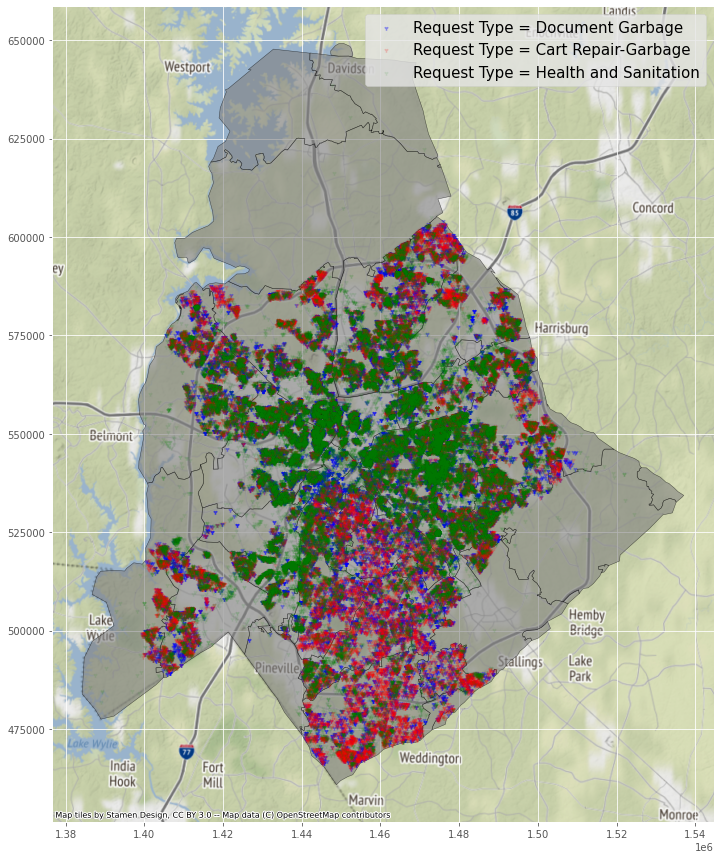

In [40]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        

geo_requests[geo_requests['REQUEST_TYPE'] == 'SW DOCUMENT GARBAGE'].plot(ax = ax, markersize = 20, color = 'blue', marker = '1', label = 'Request Type = Document Garbage', alpha =0.4, aspect=1)
geo_requests[geo_requests['REQUEST_TYPE'] == 'CART REPAIR-GARBAGE'].plot(ax = ax, markersize = 20, color = 'red', marker = '1', label = 'Request Type = Cart Repair-Garbage', alpha =0.2, aspect=1)
geo_requests[geo_requests['REQUEST_TYPE'] == 'HNS HEALTH AND SANITATION'].plot(ax = ax, markersize = 20, color = 'green', marker = '1', label = 'Request Type = Health and Sanitation', alpha =0.1, aspect=1)


plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())


# Create New Data Subsets by Fiscal Year 

In [56]:
#geo_requests_2016 = geo_requests['FISCAL_YEAR'] == 2016


geo_requests_2017 = geo_requests.loc[geo_requests["FISCAL_YEAR"] == 2017]
geo_requests_2018 = geo_requests.loc[geo_requests["FISCAL_YEAR"] == 2018]
geo_requests_2019 = geo_requests.loc[geo_requests["FISCAL_YEAR"] == 2019]
geo_requests_2020 = geo_requests.loc[geo_requests["FISCAL_YEAR"] == 2020]
geo_requests_2021 = geo_requests.loc[geo_requests["FISCAL_YEAR"] == 2021]




Graph of 4 years stacked, not very usable. Therefore two years of the first and last year to see the difference 

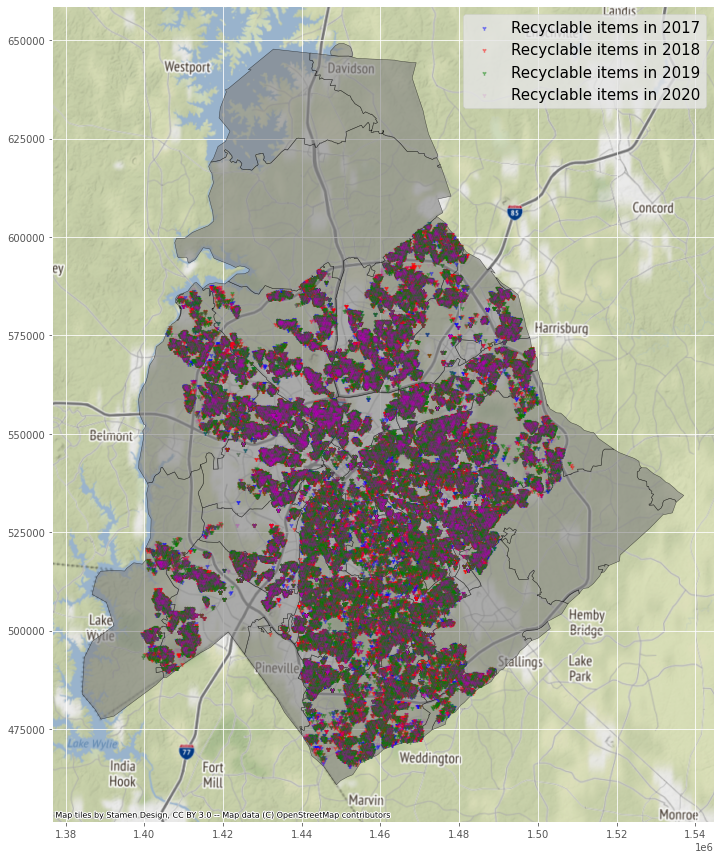

In [61]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        
geo_requests_2017[geo_requests_2017['REQUEST_TYPE'] == 'RECYCLABLE ITEMS'].plot(ax = ax, markersize = 20, color = 'blue', marker = '1', label = 'Recyclable items in 2017', alpha =0.5, aspect=1)
geo_requests_2018[geo_requests_2018['REQUEST_TYPE'] == 'RECYCLABLE ITEMS'].plot(ax = ax, markersize = 20, color = 'red', marker = '1', label = 'Recyclable items in 2018', alpha =0.5, aspect=1)
geo_requests_2019[geo_requests_2019['REQUEST_TYPE'] == 'RECYCLABLE ITEMS'].plot(ax = ax, markersize = 20, color = 'green', marker = '1', label = 'Recyclable items in 2019', alpha =0.5, aspect=1)
geo_requests_2020[geo_requests_2020['REQUEST_TYPE'] == 'RECYCLABLE ITEMS'].plot(ax = ax, markersize = 20, color = 'm', marker = '1', label = 'Recyclable items in 2020', alpha =0.1, aspect=1)




plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())


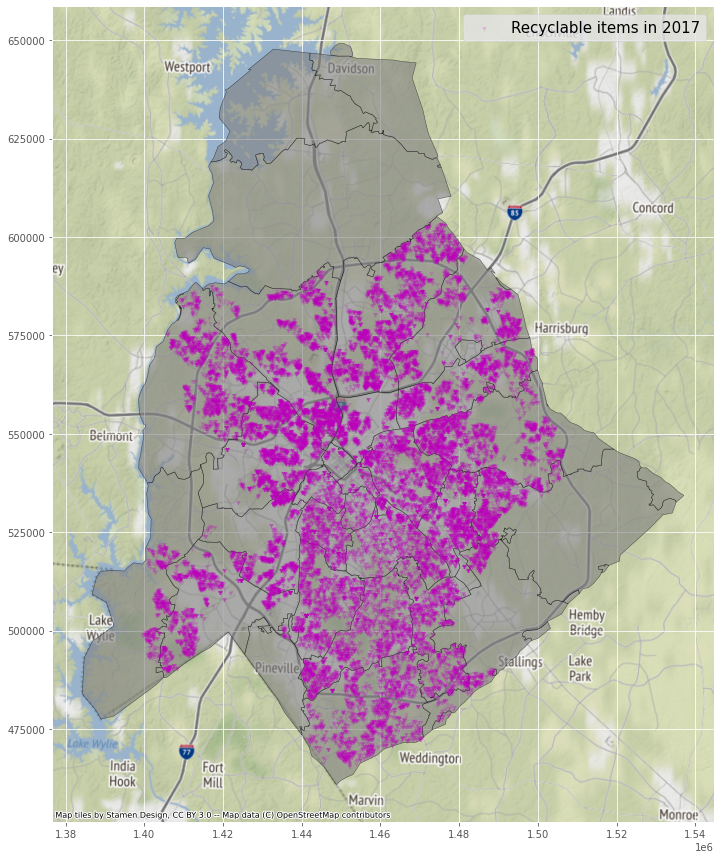

In [75]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        
geo_requests_2017[geo_requests_2017['REQUEST_TYPE'] == 'RECYCLABLE ITEMS'].plot(ax = ax, markersize = 20, color = 'm', marker = '1', label = 'Recyclable items in 2017', alpha =0.2, aspect=1)





plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())


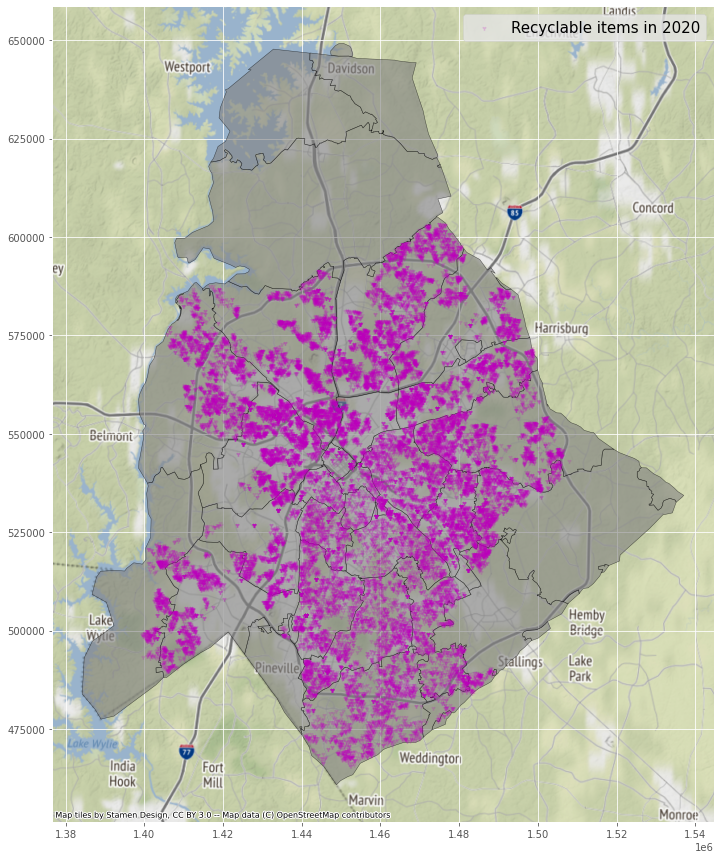

In [76]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        

geo_requests_2020[geo_requests_2020['REQUEST_TYPE'] == 'RECYCLABLE ITEMS'].plot(ax = ax, markersize = 20, color = 'm', marker = '1', label = 'Recyclable items in 2020', alpha =0.2, aspect=1)




plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())


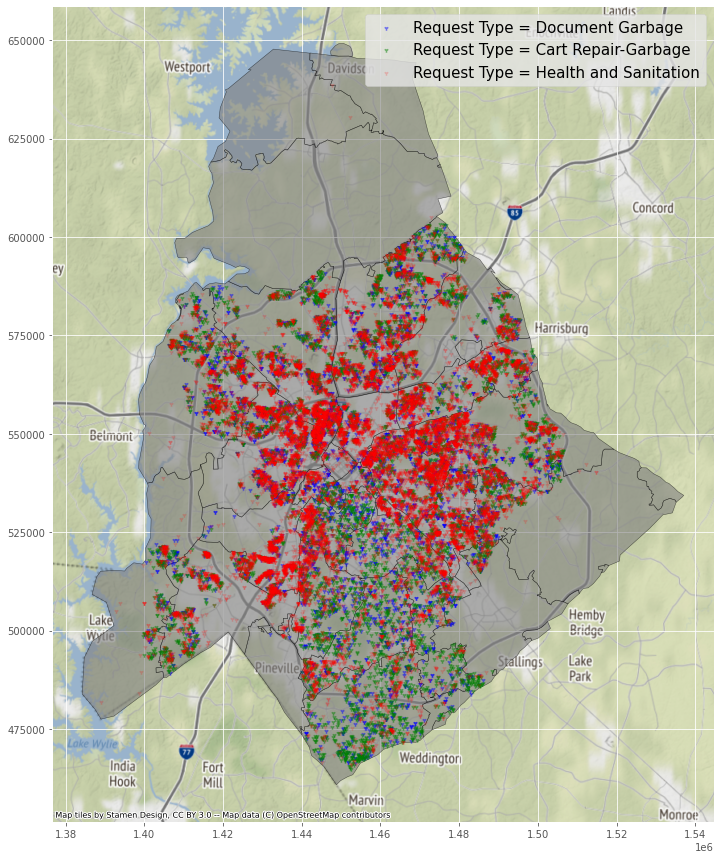

In [64]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        
geo_requests_2017[geo_requests_2017['REQUEST_TYPE'] == 'SW DOCUMENT GARBAGE'].plot(ax = ax, markersize = 20, color = 'b', marker = '1', label = 'Request Type = Document Garbage', alpha =0.5, aspect=1)
geo_requests_2017[geo_requests_2017['REQUEST_TYPE'] == 'CART REPAIR-GARBAGE'].plot(ax = ax, markersize = 20, color = 'g', marker = '1', label = 'Request Type = Cart Repair-Garbage', alpha =0.5, aspect=1)
geo_requests_2017[geo_requests_2017['REQUEST_TYPE'] == 'HNS HEALTH AND SANITATION'].plot(ax = ax, markersize = 20, color = 'r', marker = '1', label = 'Request Type = Health and Sanitation', alpha =0.2, aspect=1)





plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())


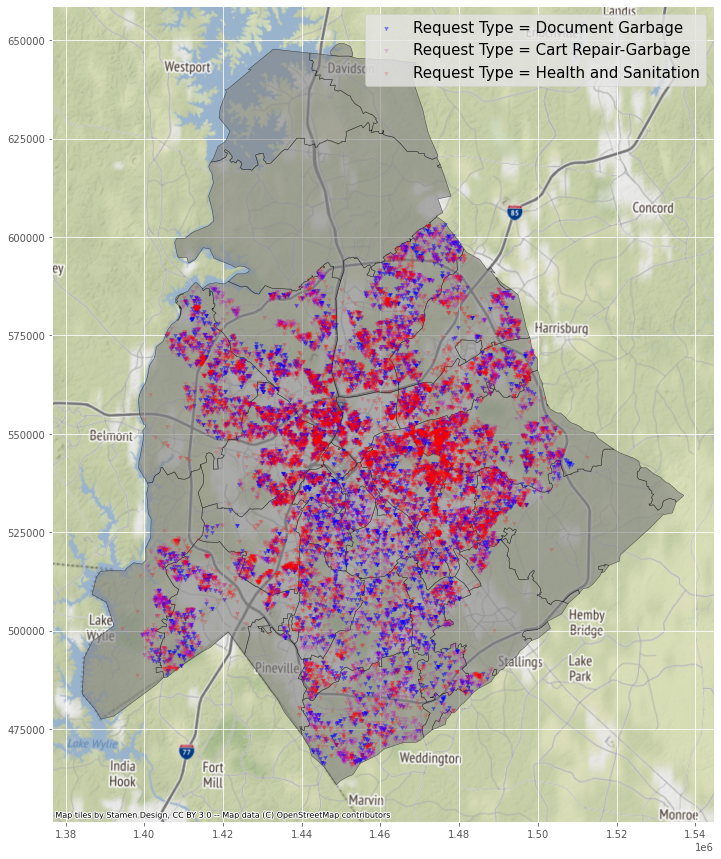

In [71]:
fig,ax = plt.subplots(figsize = (15,15))
charlotte_zipcode_map.plot(ax= ax, color='grey', edgecolor='black', alpha =0.6, lw=0.5)
        
geo_requests_2020[geo_requests_2020['REQUEST_TYPE'] == 'SW DOCUMENT GARBAGE'].plot(ax = ax, markersize = 20, color = 'b', marker = '1', label = 'Request Type = Document Garbage', alpha =0.5, aspect=1)
geo_requests_2020[geo_requests_2020['REQUEST_TYPE'] == 'CART REPAIR-GARBAGE'].plot(ax = ax, markersize = 20, color = 'm', marker = '1', label = 'Request Type = Cart Repair-Garbage', alpha =0.2, aspect=1)
geo_requests_2020[geo_requests_2020['REQUEST_TYPE'] == 'HNS HEALTH AND SANITATION'].plot(ax = ax, markersize = 20, color = 'r', marker = '1', label = 'Request Type = Health and Sanitation', alpha =0.2, aspect=1)





plt.legend(prop={'size': 15})

#adds in the highway background 
ctx.add_basemap(ax, crs=charlotte_zipcode_map.crs.to_string())

<h2> Data Preprocessing </h2>

<h2> Data Understanding and Exploration </h2>

<h2> Data Preparation for Modeling </h2>

<h2> Modeling </h2>

<h2> Evaluation </h2>

<h2> Results </h2>